In [2]:
from multiomicscellsim.cpm.simulation import CPM
from multiomicscellsim.cpm.cpmentities import CPMCellType, CPMGrid
from multiomicscellsim.cpm.constraints import VolumeConstraint, AdhesionConstraint, PerimeterConstraint

Precomputing Neighbors...


  0%|          | 0/99 [00:00<?, ?it/s]/Users/edoardo.giacomello/Projects/Voronoi/multiomicscellsim/cpm/simulation.py:69: RuntimeWarning: overflow encountered in exp
  boltzman_prob = np.exp(-total_delta_energy/self.grid.temperature)
100%|██████████| 99/99 [02:55<00:00,  1.77s/it]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


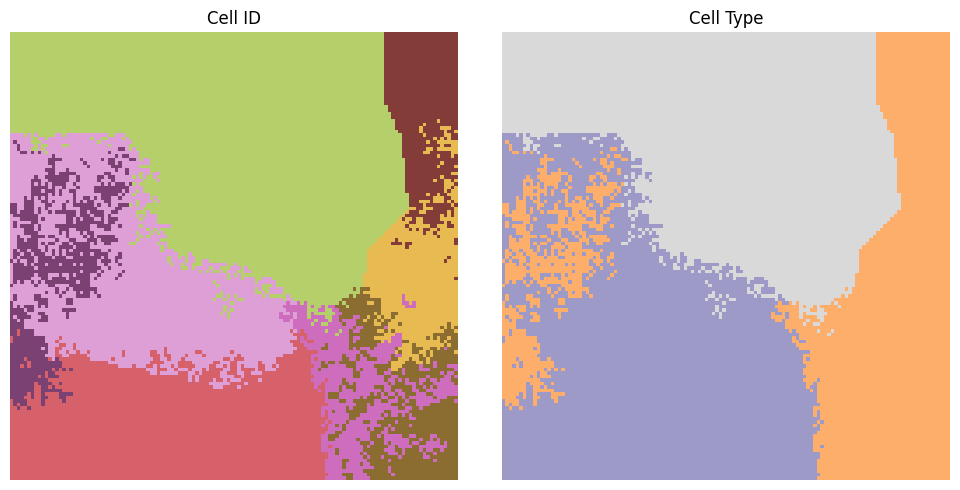

         470946352 function calls (446859928 primitive calls) in 175.299 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1149613   16.483    0.000   20.066    0.000 cpmentities.py:104(get_random_neighboring_pair)
 71309078   10.716    0.000   10.716    0.000 cpmentities.py:429(get_pixel)
  1149613    9.770    0.000   10.084    0.000 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
 50202750    9.304    0.000   16.763    0.000 cpmentities.py:435(get_cell_id)
 24081542    7.873    0.000    8.687    0.000 fields.py:919(__getattr__)
  8108379    7.867    0.000   19.418    0.000 main.py:858(__setattr__)
48164270/24082728    7.325    0.000   15.198    0.000 {built-in method builtins.hasattr}
  1131568    7.277    0.000   10.179    0.000 constraints.py:120(<listcomp>)
  1131526    6.879    0.000    9.741    0.000 constraints.py:131(<listcomp>)
  1131526    6.730    0.000    9.473    0.000 constraints.py:133(<listco

In [3]:
import math 

grid_size = 256
n_initial_cells = 10

bka = 15.0 # background adhesion
sla = 0.0 # self adhesion
ciruclar_perimeter = lambda area: int(round(2 * math.sqrt(math.pi * area))) * 4



scale_area = lambda area, grid_size=grid_size: area*grid_size*grid_size
volumes = [int(scale_area(a, grid_size=grid_size)) for a in [0.02, 0.05, 0.10]]
perimeters = [int(ciruclar_perimeter(a)) for a in volumes]

# Also defines cell type number
adhesion_matrix = [[sla, bka,  bka,  bka],
                   [bka, sla, 10.0, 15.0],
                   [bka, 10.0, sla, 15.0],
                   [bka, 15.0, 15.0, sla]]


cell_types = [
    CPMCellType(id=0, adhesion_energy=adhesion_matrix[0], name="background"),
]

n_cell_types = len(adhesion_matrix) - 1
for ct in range(n_cell_types):
    pref_volume = volumes[ct]
    pref_perimeter = perimeters[ct]
    cell_type =CPMCellType(id=ct+1, adhesion_energy=adhesion_matrix[ct], preferred_volume=pref_volume, preferred_perimeter=pref_perimeter)
    cell_types.append(cell_type)

grid = CPMGrid(
                        size=128, 
                        temperature=1.0,
                        cell_types=cell_types,
                        constraints=[
                            AdhesionConstraint(), 
                            VolumeConstraint(lambda_volume=1),
                            PerimeterConstraint(lambda_perimeter=0.1)
                            ]
                     )
cpm = CPM(grid=grid, debug=False)
grid.spawn_random_cell(n_initial_cells)
#grid.render(0)

from IPython.display import HTML
%prun -s tottime anim = cpm.render_animation(max_steps=100)
HTML(anim.to_jshtml())


# Things to check into:
# Test if the perimeter is still calculated right 
# Test what happens when cell dies (why it crashes)
# Check why the first step grows to many times with respect to the others

In [ ]:
grid.plot_stats()
for ct in cell_types:
    print(ct.preferred_perimeter)

In [ ]:
grid._cells[2]._perimeter

In [ ]:
constraint_names = [c.name for c in grid.constraints]
cpm.stats.groupby("step").describe()[constraint_names]

In [ ]:
cpm.stats.groupby("step").describe()[["d_h_adhesion", "d_h_volume", "d_h_perimeter"]]

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = cpm.stats

# Reshape the data to long format for FacetGrid compatibility
melted_data = data.melt(
    id_vars=['step', 'source_cell_id', 'target_cell_id'],
    value_vars=['d_h_adhesion', 'd_h_volume', 'd_h_perimeter'],
    var_name='d_h_metric', 
    value_name='d_h_value'
)

# Set up the FacetGrid with source_cell_id as rows and target_cell_id as columns
g = sns.FacetGrid(
    melted_data, 
    row="source_cell_id", 
    col="target_cell_id", 
    hue="d_h_metric", 
    margin_titles=True, 
    height=3,
    aspect=1.5
)

# Map the lineplot to each facet
g.map(sns.lineplot, 'step', 'd_h_value').add_legend()

# Add axis labels and titles
g.set_axis_labels("Step", "d_h Value")
g.set_titles(row_template="Source {row_name}", col_template="Target {col_name}")
g.tight_layout()

plt.show()


In [ ]:
from multiomicscellsim.cpm.simulation import CPM
from multiomicscellsim.cpm.cpmentities import CPMCellType, CPMGrid
from multiomicscellsim.cpm.constraints import VolumeConstraint, AdhesionConstraint, PerimeterConstraint
import math 

grid_size = 128
n_initial_cells = 10

bka = 15.0 # background adhesion
sla = 0.0 # self adhesion
ciruclar_perimeter = lambda area: int(round(2 * math.sqrt(math.pi * area)))



scale_area = lambda area, grid_size=grid_size: area*grid_size*grid_size
volumes = [int(scale_area(a, grid_size=grid_size)) for a in [0.02, 0.05, 0.10]]
perimeters = [int(ciruclar_perimeter(a)) for a in volumes]

# Also defines cell type number
adhesion_matrix = [[sla, bka,  bka,  bka],
                   [bka, sla, 10.0, 15.0],
                   [bka, 10.0, sla, 15.0],
                   [bka, 15.0,  15.0,  sla]]


cell_types = [
    CPMCellType(id=0, adhesion_energy=adhesion_matrix[0], name="background"),
]

n_cell_types = len(adhesion_matrix) - 1
for ct in range(n_cell_types):
    pref_volume = volumes[ct]
    pref_perimeter = perimeters[ct]
    cell_type =CPMCellType(id=ct+1, adhesion_energy=adhesion_matrix[ct], preferred_volume=pref_volume, preferred_perimeter=pref_perimeter)
    cell_types.append(cell_type)

grid = CPMGrid(
                        size=128, 
                        temperature=1.0,
                        cell_types=cell_types,
                        constraints=[
                            AdhesionConstraint(), 
                            VolumeConstraint(lambda_volume=1),
                            PerimeterConstraint(lambda_perimeter=0.1)
                            ]
                     )
cpm = CPM(grid=grid, debug=True)
grid.spawn_random_cell(n_initial_cells)
#grid.render(0)


In [ ]:
[c.perimeter for c in grid._cells]

In [ ]:
grid.render()

In [ ]:
del grid._cells[1]

In [ ]:
grid._cells